In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
from scipy.optimize import curve_fit
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import Output


# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, share_variables, calibration
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.mc import mc_tools, tof_tools
from pyccapt.calibration.leap_tools import ccapt_tools

In [2]:
# Disable showing logging in Jupyter notebook
# logging.disable(sys.maxsize)

In [3]:
button = widgets.Button(
    description='load dataset',
)
@button.on_click
def open_file_on_click(b):
    """
    Event handler for button click event.
    Prompts the user to select a dataset file and stores the selected file path in the global variable dataset_path.
    """
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [4]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_instrument_specification_selection()
display(tdc, det_diam, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos', 'ato_v6'),…

FloatText(value=78.0, description='Detector diameter:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=54.0, description='t0:')

$$\textbf{You can specify which dataset to use in below block}$$

In [69]:
# Calculate the maximum possible time of flight (TOF)
max_tof = int(tof_tools.mc2tof(max_mc.value, 1000, 0, 0, flightPathLength_d.value))
print('The maximum possible TOF is:', max_tof, 'ns')
print('=============================')
# create an instance of the Variables opject
variables = share_variables.Variables()
variables.pulse_mode = pulse_mode.value
dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
variables.dataset_name = os.path.splitext(dataset_name_with_extention)[0]
variables.result_data_path = dataset_main_path + '/' + variables.dataset_name 
variables.result_data_name = 'tof_calibration_' +  variables.dataset_name 
variables.result_path = dataset_main_path + '/' + '/tof_calibration/'

if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)

print('The data will be saved on the path:', variables.result_data_path)
print('=============================')
print('The dataset name after saving is:', variables.result_data_name)
print('=============================')
print('The figures will be saved on the path:', variables.result_path)
print('=============================')

# Create data farame out of hdf5 file dataset
data = data_tools.load_data(dataset_path, tdc.value, mode='processed')
print('Total number of Ions:', len(data))

The maximum possible TOF is: 5010 ns
The data will be saved on the path: D:/pyccapt/tests/data/OLO_AL_6_data/cropped_OLO_AL_6_data
The dataset name after saving is: tof_calibration_cropped_OLO_AL_6_data
The figures will be saved on the path: D:/pyccapt/tests/data/OLO_AL_6_data//tof_calibration/
Total number of Ions: 1943857


In [70]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse,start_counter,t_c (ns),t (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,13.903214,5258.368164,5258.368164,31579,0.0,470.575386,-2.164898,0.913714,0,0
1,0.0,0.0,0.0,0.0,27.216537,5258.368164,5258.368164,31666,0.0,634.316994,-1.572735,1.397633,87,2
2,0.0,0.0,0.0,0.0,27.464797,5258.368164,5258.368164,31784,0.0,635.626872,-1.149306,1.591837,118,1
3,0.0,0.0,0.0,0.0,26.779948,5258.368164,5258.368164,32106,0.0,638.253486,2.429143,1.518612,322,1
4,0.0,0.0,0.0,0.0,26.957527,5258.368164,5258.368164,32635,0.0,637.766568,-2.021633,-1.747837,529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943852,0.0,0.0,0.0,0.0,27.800477,5710.793945,5710.793945,24644,0.0,620.381538,-2.091673,1.286204,110,1
1943853,0.0,0.0,0.0,0.0,27.405944,5710.793945,5710.793945,24774,0.0,609.010974,-1.505878,0.684490,130,1
1943854,0.0,0.0,0.0,0.0,26.544736,5710.793945,5710.793945,24916,0.0,623.570508,3.670776,0.257878,142,1
1943855,0.0,0.0,0.0,0.0,26.813825,5710.793945,5710.793945,25014,0.0,623.460780,2.747510,2.142612,98,1


In [53]:
interact_manual(data_loadcrop.plot_crop_experiment_history, data=fixed(data), variables=fixed(variables), max_tof=widgets.FloatText(value=max_tof), frac=widgets.FloatText(value=1.0),
                bins=fixed((1200,800)), figure_size=fixed((7,3)),
               draw_rect=fixed(False), data_crop=fixed(False), pulse=widgets.Dropdown(options=[('False', False), ('True', True)]), 
                pulse_mode=widgets.Dropdown(options=[('voltage', 'voltage'), ('laser', 'laser')]), save=widgets.Dropdown(options=[('True', True), ('False', False)]),
               figname=widgets.Text(value='exp_hist'));

C:\Users\APTUser\AppData\Local\Temp\ipykernel_33088\874884481.py:1: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  interact_manual(data_loadcrop.plot_crop_experiment_history, data=fixed(data), variables=fixed(variables), max_tof=widgets.FloatText(value=max_tof), frac=widgets.FloatText(value=1.0),


interactive(children=(FloatText(value=5010.0, description='max_tof'), FloatText(value=1.0, description='frac')…

In [71]:
def exctract_data():
    # exctract needed data from Pandas data frame as an numpy array
    variables.dld_high_voltage = data['high_voltage (V)'].to_numpy()
    variables.dld_pulse = data['pulse'].to_numpy()
    variables.dld_t = data['t (ns)'].to_numpy()
    variables.dld_x_det = data['x_det (cm)'].to_numpy()
    variables.dld_y_det = data['y_det (cm)'].to_numpy()
    variables.mc = mc_tools.tof2mc(variables.dld_t, t0_d.value, variables.dld_high_voltage, variables.dld_x_det, variables.dld_y_det, flightPathLength_d.value, V_pulse=variables.dld_pulse, mode='dc_voltage')

    variables.dld_t_calib = data['t (ns)'].to_numpy()
    variables.dld_t_calib_backup = data['t (ns)'].to_numpy()
    # ion_distance = np.sqrt(flightPathLength_d.value**2 + (variables.dld_x_det*10)**2 + (variables.dld_y_det*10)**2)
    # ion_distance = flightPathLength_d.value / ion_distance
    # variables.dld_t = variables.dld_t * ion_distance
exctract_data()

In [57]:
interact_manual(tools.mc_hist_plot, variables=fixed(variables), bin_size=widgets.FloatText(value=0.1), 
                mode=widgets.Dropdown(options=[('mc', 'mc'), ('tof', 'tof')]), prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), 
                lim=widgets.IntText(value=400), percent=widgets.IntText(value=50), selector=fixed('None'), plot=fixed(True), figname=widgets.Text(value='hist'));


C:\Users\APTUser\AppData\Local\Temp\ipykernel_33088\3596624902.py:1: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  interact_manual(tools.mc_hist_plot, variables=fixed(variables), bin_size=widgets.FloatText(value=0.1),


interactive(children=(FloatText(value=0.1, description='bin_size'), Dropdown(description='mode', options=(('mc…

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

In [48]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=500, description='peak distance:')
lim_tof=widgets.IntText(value=1500, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')
index_fig = widgets.IntText(value=1, description='fig index:')

def hist_plot(variables, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        index_fig_p = index_fig.value
        selector = 'rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_tof_p], variables, bin_size_p, 
                                                                       distance=distance_p, percent=percent_p, prominence=prominence_p, selector=selector, 
                                                                       plot=plot, label='tof', fig_name=index_fig_p)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [77]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
maximum_cal_method_b = widgets.Dropdown(
    options=[('mean', 'mean'), ('histogram', 'histogram')],
    description='calib method:'
)
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, variables):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value
        maximum_cal_method_p = maximum_cal_method_b.value
        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, variables, det_diam.value, sample_size=sample_size_p, maximum_cal_method=maximum_cal_method_p,
                                         calibration_mode='tof', index_fig=index_fig_p, plot=plot_p, save=save_p)


In [78]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
peak_mode = widgets.Dropdown(
    options=[('peak', 'peak'), ('mean', 'mean'), ('median', 'median')],
    description='peak mode:'
)
def vol_correction(dld_highVoltage, variables):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        peak_mode_p = peak_mode.value
        calibration.voltage_corr_main(dld_highVoltage, variables, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p, peak_mode=peak_mode_p)


In [79]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_back_button = widgets.Button(
    description='reset back correction',
)
reset_button = widgets.Button(
    description='reset',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')
    
@plot_button.on_click
def plot_on_click(b, variables=variables, plot=True):
    hist_plot(variables, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, variables=variables, save=True):
    with out:
        clear_output(True)
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2)) 
            mask_temporal = np.logical_and((variables.dld_t_calib > variables.selected_x1),
                                           (variables.dld_t_calib < variables.selected_x2))
            x = variables.dld_x_det[mask_temporal]
            y = variables.dld_y_det[mask_temporal]
            bin_fdm_p = bin_fdm.value
            index_fig_p = index_fig.value
            bins = [bin_fdm_p, bin_fdm_p]

            calibration.plot_fdm(x, y, variables, save, bins, index_fig_p)
    
@reset_button.on_click
def reset_back_on_click(b, variables=variables, plot=True):
    variables.dld_t_calib = np.copy(variables.dld_t_calib_backup)
@reset_button.on_click
def reset_on_click(b, variables=variables, plot=True):
    exctract_data()
@save_button.on_click
def save_on_click(b, variables=variables, plot=True):
    variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)
    
@bowl_button.on_click
def bowl_on_click(b, dld_x_det=variables.dld_x_det, dld_y_det=variables.dld_y_det, dld_highVoltage=variables.dld_high_voltage, variables=variables):
    with out:
        clear_output(True)
        pb_bowl.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof ranges are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            bowl_correction(dld_x_det, dld_y_det, dld_highVoltage, variables)  
        pb_bowl.value = "<b>Flished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=variables.dld_high_voltage, variables=variables):
    with out:
        clear_output(True)
        pb_vol.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof ranges are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            vol_correction(dld_highVoltage, variables)
        pb_vol.value = "<b>Flished</b>"
    


tab1 = VBox(children=[bin_size, index_fig, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, maximum_cal_method_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, peak_mode, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_back_button, reset_button])]))
out = Output()
display(out)

Output()

In [57]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, peaks_find_plot=True, plot=plot, label='tof', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
                   print('Peaks ', i+1, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))
interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_dld_t=widgets.IntText(value=1500)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [98]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b,)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [99]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [171.45736849 445.83000897 603.93463447]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [100]:
def parametric(t, t0, c, d):

    # return c * ((t - t0)**2) + d
    return c * ((t - t0)**2) + d*t

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal, maxfev=2000)
    return fitresult

fitresult = parametric_calib(peaks_chos, variables.listMaterial)


mc_p_1 = parametric(variables.dld_t_calib, *fitresult)

C:\Users\APTUser\.conda\envs\oxcart5\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [101]:
print('The t0 is:', fitresult[0], 'ns')

The t0 is: 52.35718377338705 ns


The peak index for MRP calculation is: 2


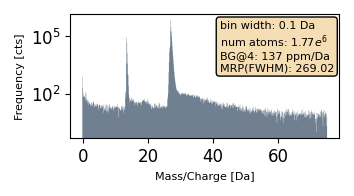

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 269.01550939358486
Peaks  0 is at location and height: (0.90, 118.00) peak window sides (half-maximum) are: (0.80, 1.00)
Peaks  1 is at location and height: (13.44, 81784.00) peak window sides (half-maximum) are: (13.34, 13.54)
Peaks  2 is at location and height: (26.97, 673199.00) peak window sides (half-maximum) are: (26.87, 26.97)


In [102]:
percent_mrp = 50
# background = {'calculation': True, 'plot_no_back': True, 'plot': False, 'mode': 'fabc', 'patch': False, 'lam': 1e4, 'num_std': 5.0}
background={'calculation': False}
peak_p, peaks_y_p, peak_widths_p, _ = tools.hist_plot(mc_p_1[mc_p_1 < 75], 0.1, prominence=40, distance=20, text_loc='right', percent=percent_mrp, plot=True, fig_name='mc2_p_1'+figname, background=background)
index_max_ini = np.argmax(peaks_y_p)
mrp = (peak_p[index_max_ini] / (peak_widths_p[index_max_ini][2] - peak_widths_p[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peak_p)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peak_p[i], peaks_y_p[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p[i][1], peak_widths_p[i][2]))

In [77]:
# np.sqrt(((1.0 * 1.66E-27 * (110 * 1E-3) ** 2)) / (2 * 1.6E-19  * 3000)) * 1E9 # in ns

144.6475601822121

In [58]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.943917,-0.463124,0.019942,91.527626,0.0,3682.110107,0.0,0.0,3891.519531,0.0,0.392873,0.057275,0,1
1,2.270334,-5.010604,0.551171,91.982094,0.0,3682.110107,0.0,0.0,3904.508789,0.0,0.702811,-0.243931,43,1
2,-5.462508,0.471533,0.547564,92.993858,0.0,3682.110107,0.0,0.0,3878.014160,0.0,-0.112540,-0.152062,211,1
3,8.305490,4.298521,1.624813,60.973576,0.0,3682.110107,0.0,0.0,3204.297363,0.0,0.712028,0.788533,66,1
4,2.990205,0.078835,0.161882,61.330170,0.0,3682.110107,0.0,0.0,3195.071777,0.0,0.512681,0.189050,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549698,-4.680508,-0.665500,8.134455,99.078377,0.0,1334.670044,0.0,0.0,6555.320312,0.0,-0.575553,-0.705528,1,1
549699,-3.787911,-3.385010,8.331511,216.163483,0.0,1334.670044,0.0,0.0,9699.115234,0.0,-0.047374,-1.282389,43,1
549700,-2.945118,-1.283401,7.480402,101.124908,0.0,1334.670044,0.0,0.0,6691.295410,0.0,-0.129701,-0.605268,114,1
549701,-4.043397,-0.999465,7.856801,100.075027,0.0,1334.670044,0.0,0.0,6614.916504,0.0,-0.393382,-0.694126,211,1


In [67]:
data_c = data.copy(deep = True)
data_c['t_c (ns)'] = variables.dld_t_calib
# data_c['mc_c (Da)'] = mc_p_1

In [68]:
# Remove negative mc
# threshold = 0
# mc_t = data_c['mc_c (Da)'].to_numpy()
# mc_t_mask = (mc_t <= threshold)
# print('The number of ions with negative mc are:', len(mc_t_mask[mc_t_mask==True]))
# data_c.drop(np.where(mc_t_mask)[0], inplace=True)
# data_c.reset_index(inplace=True, drop=True)

In [69]:
data_c

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp,t_c (ns)
0,0.943917,-0.463124,0.019942,91.527626,0.0,3682.110107,0.0,0.0,3891.519531,0.0,0.392873,0.057275,0,1,4239.131558
1,2.270334,-5.010604,0.551171,91.982094,0.0,3682.110107,0.0,0.0,3904.508789,0.0,0.702811,-0.243931,43,1,4248.225144
2,-5.462508,0.471533,0.547564,92.993858,0.0,3682.110107,0.0,0.0,3878.014160,0.0,-0.112540,-0.152062,211,1,4267.018864
3,8.305490,4.298521,1.624813,60.973576,0.0,3682.110107,0.0,0.0,3204.297363,0.0,0.712028,0.788533,66,1,3461.230088
4,2.990205,0.078835,0.161882,61.330170,0.0,3682.110107,0.0,0.0,3195.071777,0.0,0.512681,0.189050,18,1,3471.082777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549698,-4.680508,-0.665500,8.134455,99.078377,0.0,1334.670044,0.0,0.0,6555.320312,0.0,-0.575553,-0.705528,1,1,4738.564447
549699,-3.787911,-3.385010,8.331511,216.163483,0.0,1334.670044,0.0,0.0,9699.115234,0.0,-0.047374,-1.282389,43,1,7004.295261
549700,-2.945118,-1.283401,7.480402,101.124908,0.0,1334.670044,0.0,0.0,6691.295410,0.0,-0.129701,-0.605268,114,1,4787.932694
549701,-4.043397,-0.999465,7.856801,100.075027,0.0,1334.670044,0.0,0.0,6614.916504,0.0,-0.393382,-0.694126,211,1,4762.872355


In [61]:
cc = data_c['mc_c (Da)'].to_numpy()
# cc[cc <= 0] = 0
peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, distance=10, percent=50, prominence=50, selector='peak', peaks_find_plot=True, plot=True, label='mc')
peaks_ini, peaks_y_ini, peak_widths_p_ini, _ = tools.hist_plot(cc[cc < 100], 0.1, distance=10, percent=50, prominence=50, selector='peak', peaks_find_plot=True, plot=True, label='mc')

NameError: name 'mc_p_1' is not defined

In [62]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data_c, 'df')

In [63]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_c, pulse_mode=pulse_mode.value, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_c, path=variables.result_path, name=dataset_name + '.POS')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_c, variables.result_path + dataset_name + '.csv')

In [64]:
variables.result_path

'D:/pyccapt/tests/data/tof_calibration/'